In [ ]:
!pip install scikit-learn pandas


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample


In [ ]:
import pandas as pd
train_df = pd.read_excel('hate_sample_for_finetune.xlsx')
train_df = train_df.dropna(subset=['hate_type_teacher'])
print("Train shape:", train_df.shape)


Train shape: (1988, 7)


In [ ]:
# --- Balance classes ---
df_majority = train_df[train_df['hate_type_teacher'] == 'sarcasm-based hate']
df_minority = train_df[train_df['hate_type_teacher'] != 'sarcasm-based hate']

# Oversample minority classes to match majority count
df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

In [ ]:
# Combine and shuffle
df_balanced = pd.concat([df_majority, df_minority_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_balanced['hate_type_teacher'].value_counts())

hate_type_teacher
sarcasm-based hate        1267
metaphor-based hate        530
meme-language hate         321
humor-based hate           221
political framing hate     195
Name: count, dtype: int64


In [ ]:
# --- Encode labels ---
label_mapping = {label: idx for idx, label in enumerate(df_balanced['hate_type_teacher'].unique())}
df_balanced['hate_type_teacher_int'] = df_balanced['hate_type_teacher'].map(label_mapping)
print("Label mapping:", label_mapping)

Label mapping: {'metaphor-based hate': 0, 'sarcasm-based hate': 1, 'humor-based hate': 2, 'meme-language hate': 3, 'political framing hate': 4}


In [ ]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced['clean_text'],
    df_balanced['hate_type_teacher_int'],
    test_size=0.2,
    random_state=42,
    stratify=df_balanced['hate_type_teacher_int']
)

In [ ]:
# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
# Train Naive Bayes Classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred = nb_classifier.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.757396449704142
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.82      0.90       106
           1       0.67      1.00      0.81       254
           2       1.00      0.27      0.43        44
           3       1.00      0.44      0.61        64
           4       1.00      0.08      0.14        39

    accuracy                           0.76       507
   macro avg       0.93      0.52      0.58       507
weighted avg       0.84      0.76      0.72       507



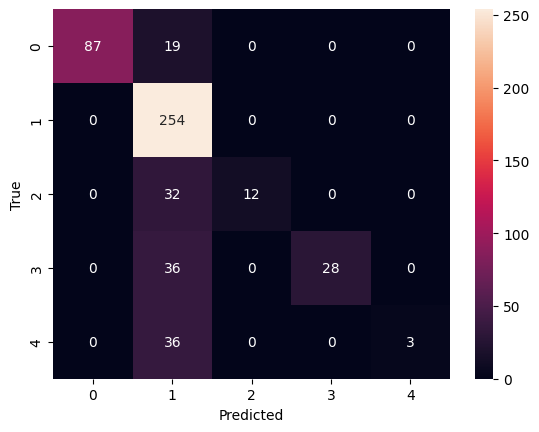

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
